In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels

In [2]:
# Upload file kaggle.json yang berisi API Key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucascha","key":"6ee5fce662be883e09df2bfb406e4795"}'}

In [3]:
# Simpan kaggle.json ke direktori yang sesuai
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# #Download dataset dari Kaggle
!kaggle datasets download -d anasfikrihanif/indonesian-food-and-drink-nutrition-dataset

# Ekstrak file zip
!unzip -q indonesian-food-and-drink-nutrition-dataset.zip -d nutrition_dataset

Dataset URL: https://www.kaggle.com/datasets/anasfikrihanif/indonesian-food-and-drink-nutrition-dataset
License(s): CC0-1.0
  0% 0.00/73.7k [00:00<?, ?B/s]
100% 73.7k/73.7k [00:00<00:00, 332MB/s]


In [5]:
df = pd.read_csv('/content/nutrition_dataset/nutrition.csv')
df.head()

,id,calories,proteins,fat,carbohydrate,name,image
0,1,280.0,9.2,28.4,0.0,Abon,https://img-cdn.medkomtek.com/PbrY9X3ignQ8sVuj...
1,2,513.0,23.7,37.0,21.3,Abon haruwan,https://img-global.cpcdn.com/recipes/cbf330fbd...
2,3,0.0,0.0,0.2,0.0,Agar-agar,https://res.cloudinary.com/dk0z4ums3/image/upl...
3,4,45.0,1.1,0.4,10.8,Akar tonjong segar,https://images.tokopedia.net/img/cache/200-squ...
4,5,37.0,4.4,0.5,3.8,Aletoge segar,https://nilaigizi.com/assets/images/produk/pro...


In [6]:
df.drop(['id', 'image'], axis=1, inplace=True)

In [7]:
# Memastikan kolom 'name' berada di posisi pertama
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('name')))
df = df[cols]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1346 entries, 0 to 1345
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          1346 non-null   object 
 1   calories      1346 non-null   float64
 2   proteins      1346 non-null   float64
 3   fat           1346 non-null   float64
 4   carbohydrate  1346 non-null   float64
dtypes: float64(4), object(1)
memory usage: 52.7+ KB


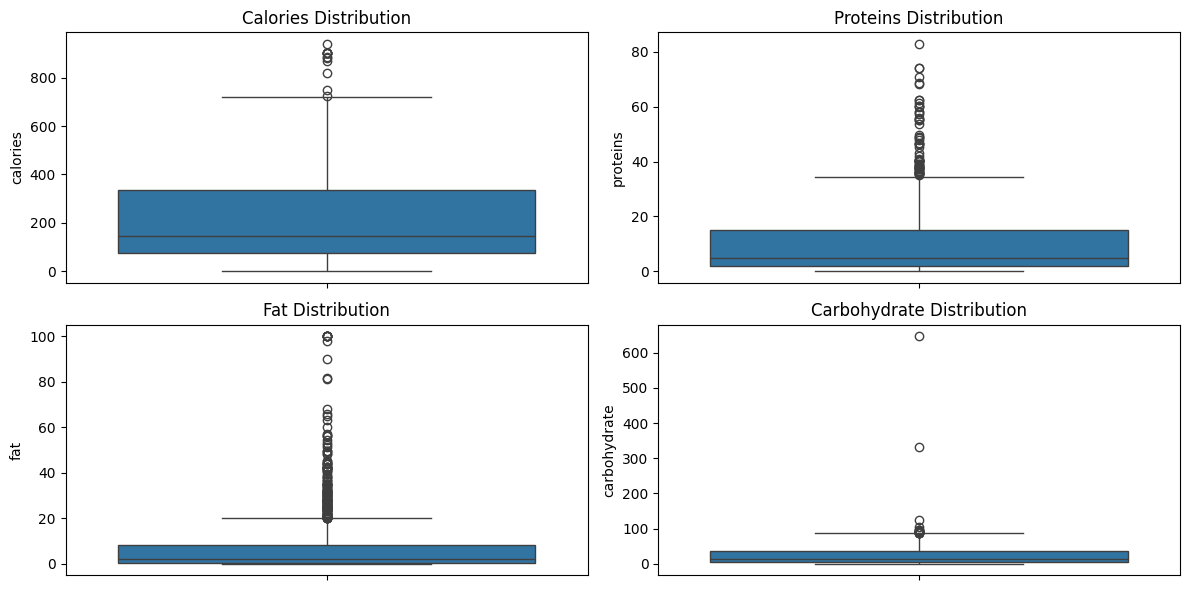

In [9]:
# Create box plots for 'calories', 'proteins', 'fat', and 'carbohydrate'
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.boxplot(y=df['calories'])
plt.title('Calories Distribution')

plt.subplot(2, 2, 2)
sns.boxplot(y=df['proteins'])
plt.title('Proteins Distribution')

plt.subplot(2, 2, 3)
sns.boxplot(y=df['fat'])
plt.title('Fat Distribution')

plt.subplot(2, 2, 4)
sns.boxplot(y=df['carbohydrate'])
plt.title('Carbohydrate Distribution')

plt.tight_layout()
plt.show()


In [10]:
def classify_calories(value):
    if value <= 100:
        return 'Rendah'
    elif value <= 200:
        return 'Sedang'
    else:
        return 'Tinggi'

def classify_protein(value):
    if value <= 5:
        return 'Rendah'
    elif value <= 10:
        return 'Sedang'
    else:
        return 'Tinggi'

def classify_fat(value):
    if value <= 5:
        return 'Rendah'
    elif value <= 15:
        return 'Sedang'
    else:
        return 'Tinggi'

def classify_carbohydrate(value):
    if value <= 10:
        return 'Rendah'
    elif value <= 20:
        return 'Sedang'
    else:
        return 'Tinggi'

In [11]:
# Mengklasifikasikan nilai gizi sesuai kategori tetap
df['calories_category'] = df['calories'].apply(classify_calories)
df['proteins_category'] = df['proteins'].apply(classify_protein)
df['fat_category'] = df['fat'].apply(classify_fat)
df['carbohydrate_category'] = df['carbohydrate'].apply(classify_carbohydrate)

# Melihat distribusi
for nutrient in ['calories', 'proteins', 'fat', 'carbohydrate']:
    print(f'Distribusi {nutrient}:')
    print(df[f'{nutrient}_category'].value_counts())
    print()

Distribusi calories:
calories_category
Tinggi    529
Rendah    470
Sedang    347
Name: count, dtype: int64

Distribusi proteins:
proteins_category
Rendah    678
Tinggi    481
Sedang    187
Name: count, dtype: int64

Distribusi fat:
fat_category
Rendah    915
Sedang    222
Tinggi    209
Name: count, dtype: int64

Distribusi carbohydrate:
carbohydrate_category
Rendah    571
Tinggi    555
Sedang    220
Name: count, dtype: int64



In [12]:
df.head()

,name,calories,proteins,fat,carbohydrate,calories_category,proteins_category,fat_category,carbohydrate_category
0,Abon,280.0,9.2,28.4,0.0,Tinggi,Sedang,Tinggi,Rendah
1,Abon haruwan,513.0,23.7,37.0,21.3,Tinggi,Tinggi,Tinggi,Tinggi
2,Agar-agar,0.0,0.0,0.2,0.0,Rendah,Rendah,Rendah,Rendah
3,Akar tonjong segar,45.0,1.1,0.4,10.8,Rendah,Rendah,Rendah,Sedang
4,Aletoge segar,37.0,4.4,0.5,3.8,Rendah,Rendah,Rendah,Rendah


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

# Fungsi klasifikasi yang lebih fleksibel berdasarkan kombinasi kategori
category_map = {
    #calories_category, proteins_category, fat_category, carbohydrate_category
    ('Rendah', 'Tinggi', 'Rendah', 'Sedang'): 'Sehat',
    ('Sedang', 'Sedang', 'Sedang', 'Sedang'): 'Bergizi',
    ('Tinggi', 'Tinggi', 'Tinggi', 'Tinggi'): 'Tinggi Energi',
    ('Rendah', 'Rendah', 'Rendah', 'Rendah'): 'Tidak Sehat',
    ('Tinggi', 'Sedang', 'Rendah', 'Sedang'): 'Tinggi Kalori',
    ('Sedang', 'Tinggi', 'Rendah', 'Rendah'): 'Tinggi Protein',
    ('Sedang', 'Rendah', 'Tinggi', 'Rendah'): 'Tinggi Lemak',
    ('Sedang', 'Rendah', 'Rendah', 'Tinggi'): 'Tinggi Karbohidrat',
    ('Rendah', 'Tinggi', 'Rendah', 'Rendah'): 'Diet Rendah Lemak',
    ('Sedang', 'Tinggi', 'Sedang', 'Rendah'): 'Diet Rendah Karbohidrat',
    ('Sedang', 'Rendah', 'Rendah', 'Tinggi'): 'Diet Tinggi Serat',
    ('Rendah', 'Rendah', 'Rendah', 'Sedang'): 'Rendah Kalori & Karbo',
    ('Rendah', 'Rendah', 'Sedang', 'Rendah'): 'Rendah Kalori & Protein',
    ('Rendah', 'Rendah', 'Sedang', 'Sedang'): 'Rendah Lemak & Kalori',
    ('Rendah', 'Sedang', 'Rendah', 'Rendah'): 'Rendah Karbo & Kalori',
    ('Rendah', 'Sedang', 'Rendah', 'Sedang'): 'Rendah Lemak, Kalori, Karbo',
    ('Rendah', 'Sedang', 'Sedang', 'Rendah'): 'Rendah Karbo & Tinggi Lemak',
    ('Rendah', 'Sedang', 'Sedang', 'Sedang'): 'Rendah Kalori, Tinggi Lemak, Protein',
    ('Sedang', 'Rendah', 'Rendah', 'Rendah'): 'Rendah Gizi Umum',
    ('Sedang', 'Rendah', 'Rendah', 'Sedang'): 'Tinggi Karbo, Rendah Gizi',
    ('Sedang', 'Rendah', 'Sedang', 'Rendah'): 'Tinggi Lemak, Rendah Protein & Karbo',
    ('Sedang', 'Rendah', 'Sedang', 'Sedang'): 'Tinggi Lemak & Karbo',
    ('Sedang', 'Sedang', 'Rendah', 'Rendah'): 'Seimbang Rendah Lemak & Karbo',
    ('Sedang', 'Sedang', 'Rendah', 'Sedang'): 'Rendah Lemak, Seimbang lainnya',
    ('Sedang', 'Sedang', 'Sedang', 'Rendah'): 'Rendah Karbo, Seimbang lainnya',
}

# Fungsi untuk menentukan kategori makanan secara otomatis
def kategori_makanan(calories_category, proteins_category, fat_category, carbohydrate_category):
    key = (calories_category, proteins_category, fat_category, carbohydrate_category)

    # Kategori default jika kombinasi tidak ada dalam peta
    if key not in category_map:
        if calories_category == 'Tinggi':
            return 'Tinggi Kalori'
        elif proteins_category == 'Tinggi':
            return 'Tinggi Protein'
        elif fat_category == 'Tinggi':
            return 'Tinggi Lemak'
        elif carbohydrate_category == 'Tinggi':
            return 'Tinggi Karbohidrat'
        else:
            return 'Lainnya'

    return category_map[key]



# Menggunakan data yang sudah ada
df['category'] = df.apply(lambda row: kategori_makanan(row['calories_category'], row['proteins_category'], row['fat_category'], row['carbohydrate_category']), axis=1)

# Melihat distribusi kategori
print(df['category'].value_counts())


category
Tinggi Kalori                           477
Tidak Sehat                             214
Diet Tinggi Serat                       115
Rendah Kalori & Karbo                   108
Tinggi Protein                          107
Diet Rendah Lemak                        63
Tinggi Energi                            52
Tinggi Karbohidrat                       52
Diet Rendah Karbohidrat                  47
Rendah Karbo & Kalori                    24
Rendah Lemak, Kalori, Karbo              15
Tinggi Karbo, Rendah Gizi                14
Tinggi Lemak, Rendah Protein & Karbo     13
Rendah Kalori & Protein                  10
Rendah Karbo, Seimbang lainnya            9
Tinggi Lemak & Karbo                      9
Bergizi                                   5
Rendah Karbo & Tinggi Lemak               4
Rendah Lemak, Seimbang lainnya            4
Seimbang Rendah Lemak & Karbo             2
Tinggi Lemak                              1
Rendah Lemak & Kalori                     1
Name: count, dtype: int

In [14]:
# Melihat kombinasi yang menghasilkan kategori 'Lainnya'
kategori_list = ['Rendah', 'Sedang', 'Tinggi']
semua_kombinasi = list(product(kategori_list, repeat=4))

print("Kombinasi Kategori yang Termasuk 'Lainnya':")
for kombinasi in semua_kombinasi:
    if kategori_makanan(*kombinasi) == 'Lainnya':
        print(f"{kombinasi}: {kategori_makanan(*kombinasi)}")

Kombinasi Kategori yang Termasuk 'Lainnya':


In [15]:
df.head()

,name,calories,proteins,fat,carbohydrate,calories_category,proteins_category,fat_category,carbohydrate_category,category
0,Abon,280.0,9.2,28.4,0.0,Tinggi,Sedang,Tinggi,Rendah,Tinggi Kalori
1,Abon haruwan,513.0,23.7,37.0,21.3,Tinggi,Tinggi,Tinggi,Tinggi,Tinggi Energi
2,Agar-agar,0.0,0.0,0.2,0.0,Rendah,Rendah,Rendah,Rendah,Tidak Sehat
3,Akar tonjong segar,45.0,1.1,0.4,10.8,Rendah,Rendah,Rendah,Sedang,Rendah Kalori & Karbo
4,Aletoge segar,37.0,4.4,0.5,3.8,Rendah,Rendah,Rendah,Rendah,Tidak Sehat


In [16]:
# One-hot encoding untuk fitur kategorikal
X = pd.get_dummies(df[['calories_category', 'proteins_category', 'fat_category', 'carbohydrate_category']])

In [17]:
# Encode target label menjadi angka
target = 'category'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df[target])

In [18]:
# Konversi y ke one-hot vector (keras categorical_crossentropy expects one-hot)
y_cat = tf.keras.utils.to_categorical(y)

In [19]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X.values, y_cat, test_size=0.2, random_state=42)

In [20]:
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_cat.shape[1], activation='softmax')  # output layer sesuai jumlah kelas
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.1057 - loss: 3.0147 - val_accuracy: 0.6574 - val_loss: 2.4969
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5427 - loss: 2.2161 - val_accuracy: 0.6157 - val_loss: 1.4885
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6678 - loss: 1.2977 - val_accuracy: 0.7593 - val_loss: 1.0741
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7669 - loss: 0.9333 - val_accuracy: 0.7963 - val_loss: 0.8055
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8003 - loss: 0.7137 - val_accuracy: 0.8102 - val_loss: 0.6341
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8402 - loss: 0.5486 - val_accuracy: 0.8194 - val_loss: 0.5329
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8966 - loss: 0.4108 - val_accuracy: 0.8657 - val_loss: 0.4538
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9159 - loss: 0.3355 - val_accuracy: 0.9074 - val_loss

Akurasi pada data test: 0.9963
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
                                      precision    recall  f1-score   support

                             Bergizi       1.00      1.00      1.00         1
             Diet Rendah Karbohidrat       1.00      1.00      1.00         9
                   Diet Rendah Lemak       1.00      1.00      1.00        13
                   Diet Tinggi Serat       1.00      1.00      1.00        21
               Rendah Kalori & Karbo       0.96      1.00      0.98        26
             Rendah Kalori & Protein       1.00      1.00      1.00         3
               Rendah Karbo & Kalori       1.00      1.00      1.00         6
         Rendah Karbo & Tinggi Lemak       1.00      1.00      1.00         1
      Rendah Karbo, Seimbang lainnya       1.00      1.00      1.00         1
               Rendah Lemak & Kalori       0.00      0.00      0.00         0
         Rendah Lemak, Kalori, Karbo       1.00      1.00      1.00     

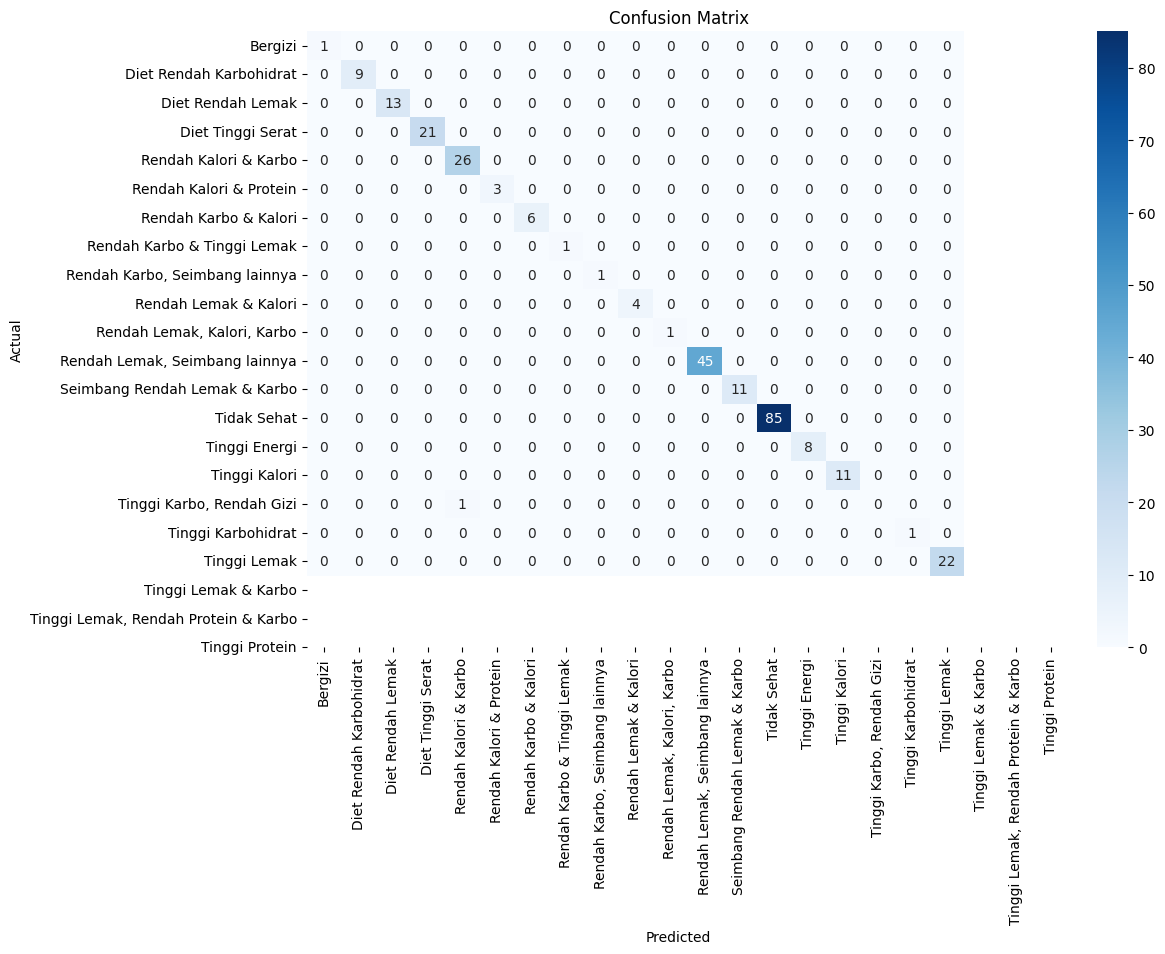

In [22]:
# Evaluasi di data test
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Akurasi pada data test: {acc:.4f}")

# Prediksi
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


# Classification report
all_labels = list(range(len(label_encoder.classes_)))
print(classification_report(
    y_true,
    y_pred_classes,
    labels=all_labels,
    target_names=label_encoder.classes_,
    zero_division=0  # Hindari error jika precision/recall-nya 0
))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [23]:
# Simpan model
model.save("model_nutrition_tf.keras")

In [24]:
# prompt: simpan dataset hasil ke format jsonl

# Convert DataFrame to JSONL format
# jsonl stands for "JSON Lines"
# Each row is a JSON object, and each object is on its own line.
jsonl_output = df.to_json(orient='records', lines=True)

# Specify the output file path
output_file_path = 'dataset_nutrition.jsonl'

# Write the JSONL output to a file
with open(output_file_path, 'w') as f:
    f.write(jsonl_output)

print(f"Dataset berhasil disimpan dalam format JSONL ke '{output_file_path}'")

# Optional: Display the first few lines of the generated JSONL file
!head -n 5 {output_file_path}

Dataset berhasil disimpan dalam format JSONL ke 'dataset_nutrition.jsonl'
{"name":"Abon","calories":280.0,"proteins":9.2,"fat":28.4,"carbohydrate":0.0,"calories_category":"Tinggi","proteins_category":"Sedang","fat_category":"Tinggi","carbohydrate_category":"Rendah","category":"Tinggi Kalori"}
{"name":"Abon haruwan","calories":513.0,"proteins":23.7,"fat":37.0,"carbohydrate":21.3,"calories_category":"Tinggi","proteins_category":"Tinggi","fat_category":"Tinggi","carbohydrate_category":"Tinggi","category":"Tinggi Energi"}
{"name":"Agar-agar","calories":0.0,"proteins":0.0,"fat":0.2,"carbohydrate":0.0,"calories_category":"Rendah","proteins_category":"Rendah","fat_category":"Rendah","carbohydrate_category":"Rendah","category":"Tidak Sehat"}
{"name":"Akar tonjong segar","calories":45.0,"proteins":1.1,"fat":0.4,"carbohydrate":10.8,"calories_category":"Rendah","proteins_category":"Rendah","fat_category":"Rendah","carbohydrate_category":"Sedang","category":"Rendah Kalori & Karbo"}
{"name":"Aletog